# Spanish Translation A/B Test

* [Challenge Description](#Challenge-Description)
* [Data Explaination](#Data)
* [Load Dataset](#Load-Dataset)
* [AB Test](#A/B-Test)
* [Analyze AB Test Result](#Analysis)

## Challenge Description
Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.

* Control group:  All Spanish-speaking countries had the same translation of the site which was written by a Spaniard.
* Test group: each country would have its one translation written by a local.

After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!

Objectives:
* Confirm if the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
* Explain why that might be happening. Are the localized translations really worse?

## Data
The 2 tables are: 
1. "test_table" - general information about the test results
**Columns:**
* **user_id** : the id of the user. Unique by user. Can be joined to user id in the other table.
    * For each user, we just check whether conversion happens the first time they land on the site since the test started.
* **date** : when they came to the site for the first time since the test started
* **source** : marketing channel: Ads, SEO, Direct . Direct means everything except for ads and SEO. Such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.
* **device** : device used by the user. It can be mobile or web
* **browser_language** : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish) 
* **ads_channel** : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this field is NA
* **browser** : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera
* **conversion** : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.
* **test** : users are randomly split into test (1) and control (0). Test users see the new translation and control users see the old one. For Spain-based users, this is obviously always 0 since there is no change there.

2. "user_table" - some information about the user
**Columns:**
* **user_id** : the id of the user. It can be joined to user id in the other table
* **sex** : user sex: Male or Female
* **age** : user age (self-reported)
* **country** : user country based on ip address

In [1]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

%matplotlib inline

# Load Dataset

In [2]:
test = pd.read_csv('02_spanish_translation_ AB_test_test_table.csv')
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [4]:
test.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [5]:
for column in test.columns:
    uniques = test[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

user_id              453321	 [315281 497851 848402 290051 548435]
date                     5	 ['2015-12-03' '2015-12-04' '2015-11-30' '2015-12-01' '2015-12-02']
source                   3	 ['Direct' 'Ads' 'SEO']
device                   2	 ['Web' 'Mobile']
browser_language         3	 ['ES' 'Other' 'EN']
ads_channel              6	 [nan 'Google' 'Facebook' 'Bing' 'Yahoo']
browser                  7	 ['IE' 'Chrome' 'Android_App' 'FireFox' 'Iphone_App']
conversion               2	 [1 0]
test                     2	 [0 1]


In [6]:
user = pd.read_csv('02_spanish_translation_ AB_test_user_table.csv')
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [7]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [8]:
user.describe()

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


In [9]:
for column in user.columns:
    uniques = user[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

user_id              452867	 [765821 343561 118744 987753 554597]
sex                      2	 ['M' 'F']
age                     52	 [20 27 23 29 31]
country                 17	 ['Mexico' 'Nicaragua' 'Colombia' 'Venezuela' 'Spain']


In [10]:
# check uniqueness
print('Test user_id:\t', len(test['user_id'].unique()), '\t', len(test['user_id'].unique()) == len(test))
print('User user_id:\t', len(user['user_id'].unique()), '\t', len(user['user_id'].unique()) == len(user))

Test user_id:	 453321 	 True
User user_id:	 452867 	 True


In [11]:
# merge two tables

df = pd.merge(left=test, right=user, how='left', on='user_id')
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           453321 non-null  int64  
 1   date              453321 non-null  object 
 2   source            453321 non-null  object 
 3   device            453321 non-null  object 
 4   browser_language  453321 non-null  object 
 5   ads_channel       181877 non-null  object 
 6   browser           453321 non-null  object 
 7   conversion        453321 non-null  int64  
 8   test              453321 non-null  int64  
 9   sex               452867 non-null  object 
 10  age               452867 non-null  float64
 11  country           452867 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


# A/B Test

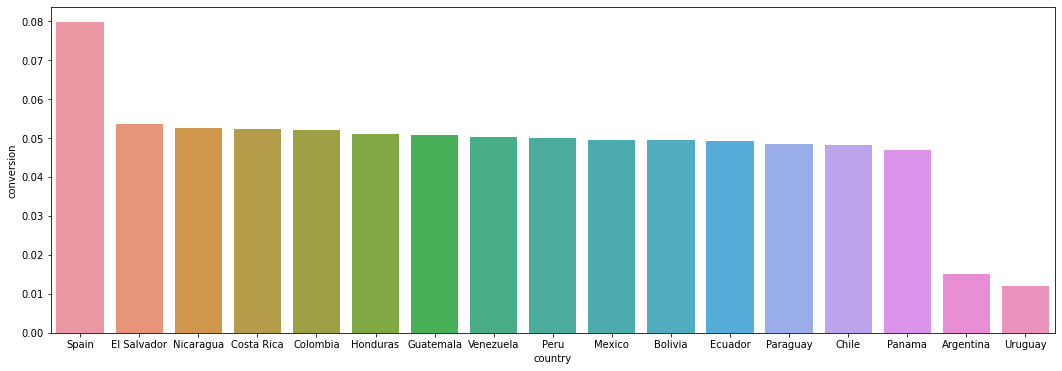

In [13]:
# check if the convertion rate is much higher in Spain than the rest of LatAm countries in the control group (0) 

groupby_country = df[df['test'] == 0][['conversion', 'country']].groupby('country').mean().reset_index()
groupby_country = groupby_country.sort_values('conversion', ascending=False)

# visualization

fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x='country', y='conversion', data=groupby_country, ax=ax)
plt.show()


* In control group, the plot above shows that Spain has better conversion rate than other countries.

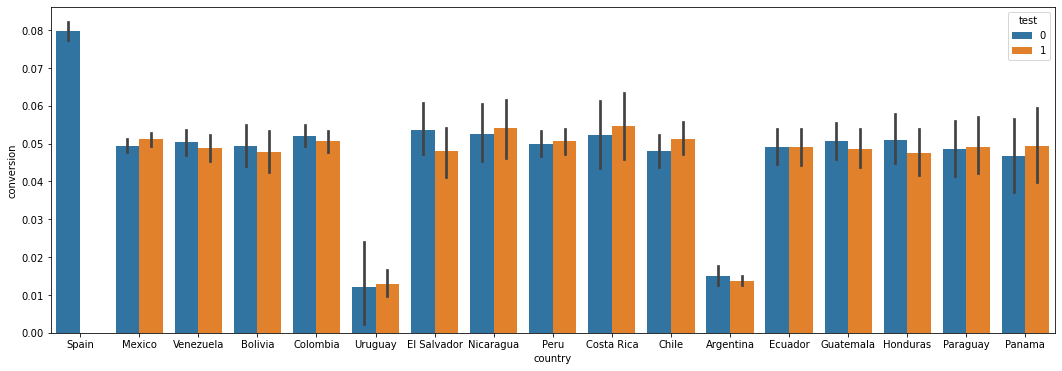

In [14]:
# visualize the conversion rate between test and contral group in different countries

fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x='country', y='conversion', hue='test', data=df, ax=ax)
plt.show()

Example:
* Mexico: the conversion rate in test group is 0.049495 (# of converted users/ total # of mexican users in test group), the conversion rate in control group is 0.051186.

In [15]:
# A/B test result

test_data = df[df['country'] != 'Spain']
test_val = test_data[test_data['test'] == 1]['conversion'].values
cont_val = test_data[test_data['test'] == 0]['conversion'].values

print("average of conversion rate in test group: " + str(test_val.mean()))
print("average of conversion rate in control group: " + str(cont_val.mean()))

average of conversion rate in test group: 0.043424713982118966
average of conversion rate in control group: 0.04833042316066309


In [16]:
# check statistical significance
# check t test for the means of two independent samples

print('length of test_val:' + str(len(test_val)))
print('length of cont_val:' + str(len(cont_val)))

print(ttest_ind(test_val, cont_val, equal_var=False))  # not equal population

length of test_val:215983
length of cont_val:185556
Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)


The overall P value is extremely low. There is significant evidence to say the convertion rate in test group is worse than control group which means the localized translations are worse. We can reject the null hypothesis. 

# Analysis
* To discover the reason why localized transalation is doing worse.

In [17]:
df_new = df[df['country'] != 'Spain']
df_new.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico


In [18]:
# show the conversion rate by countries for control group and test group.

countries = [name for name in df_new['country'].unique() if name is not np.nan]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = df_new[(df_new['country'] == country) & (df_new['test'] == 1)]['conversion'].values
    cont_val = df_new[(df_new['country'] == country) & (df_new['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10.6f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849  

The p-value for each country indicates that the differences are not significant to draw any conclusions. 

This is the opposite the conclustion when comparing the overall conversion rate for test and the control group. When we look at the data grouped by country, we don't observe a significant difference, there is likely a bias in the data selection by country.

We can verify it by counting the data by country and test group.

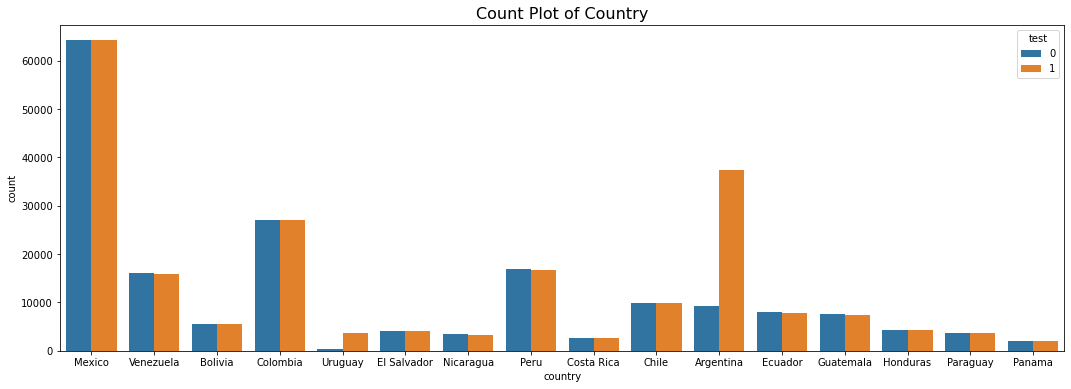

In [19]:
# visualization of different countries

fig, ax = plt.subplots(figsize=(18,6))
sns.countplot(x='country', hue='test', data=df_new, ax=ax)
ax.set_title('Count Plot of Country', fontsize=16)

plt.show()

* For Uruguay and Argentina, data is not split evenly between control group and test group which may cause the overall p-value result is not reliable. 

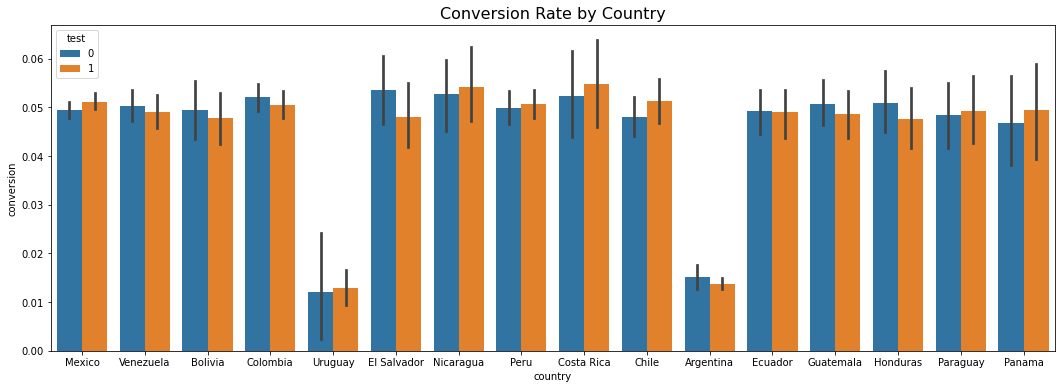

In [20]:
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x='country', y='conversion', hue='test', data=df_new, ax=ax)
ax.set_title('Conversion Rate by Country', fontsize=16)
plt.show()

In [21]:
df_new.groupby('country')['test'].value_counts(normalize=True).to_frame(name='value_cnt_perc').reset_index()

,country,test,value_cnt_perc
0,Argentina,1,0.799799
1,Argentina,0,0.200201
2,Bolivia,1,0.501079
3,Bolivia,0,0.498921
4,Chile,1,0.500785
5,Chile,0,0.499215
6,Colombia,0,0.501073
7,Colombia,1,0.498927
8,Costa Rica,0,0.501036
9,Costa Rica,1,0.498964


Except Argentina and Uruguay, we can see the data was split evenly among all other countries. But for Argentina, 80% of the users were part of the test group; for Uruguay, 90% of the users were part of the test group.


# Conclusion

So we can't reject null hypothesis that the test conversion rates were worse than control's. The conversion rates were better in some countries in test group but the differences are not significant enough to validate the use of localized translations. 

In future data collecting, we need to make sure evenly collect data between control group and test group for each country so that we can reduce the opportunity of having biased result. 

It might be worth considering to run these tests for a long period of time since the conversion rate has not been affected significantly.